In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA, LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

def submit_csv(predict):
    result = pd.DataFrame(columns=['id','label'])
    result['id'] = np.arange(1,len(predict)+1)
    result['label'] = predict
    result.to_csv('answer.csv',index=False, sep=',', header=True)
    
def get_result_from_grid_cv(search, gr_cv):
    f1_macro = search['mean_test_f1_macro'][np.argmin(search['rank_test_f1_macro'])]
    precision_macro = search['mean_test_precision_macro'][np.argmin(search['rank_test_precision_macro'])]
    recall_macro = search['mean_test_recall_macro'][np.argmin(search['rank_test_recall_macro'])]
    print(gr_cv.best_params_,'\n', 'best_accuracy: ', gr_cv.best_score_)
    print('f1_macro_best:', f1_macro, '\n', 'precision_macro_best:', precision_macro,'\n', 'recall_macro_best:', recall_macro)

In [3]:
df = pd.read_csv('fashion-mnist_train.csv')
df_test = pd.read_csv('new_test.csv')

In [4]:
df_test.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,31,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0


In [5]:
X_valid = np.array(df_test)
X = np.array(df.loc[:, 'pixel1':])
y = np.array(df.loc[:, 'label'])

X_all = np.concatenate([X, X_valid])
X_all.shape

(70000, 784)

In [29]:
# понижаем всю выборку 70000 признаков
scaler = StandardScaler()
X_all_scale = scaler.fit_transform(X_all)

X_embedded = TSNE(n_components=2, perplexity=30).fit_transform(X_all) 

In [13]:
# понижаем всю выборку 70000 признаков с предварительным PCA
scaler = StandardScaler()
X_all_scale = scaler.fit_transform(X_all)

X_pca = PCA(n_components=30).fit_transform(X_all_scale)
X_pca_embedded = TSNE(n_components=2, perplexity=30).fit_transform(X_pca)

In [34]:
# понижаем всю выборку 70000 признаков с PCA
scaler = StandardScaler()
X_all_scale = scaler.fit_transform(X_all)

X_pca = PCA(n_components=30).fit_transform(X_all)

#### T-SNE

Text(0.5, 1.0, 'Результат применения t-sne')

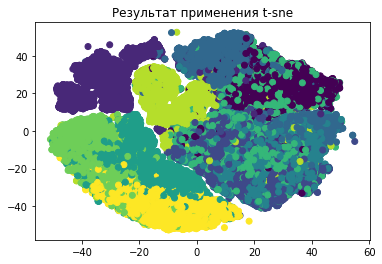

In [30]:
plt.scatter(X_embedded[:60000,0], X_embedded[:60000,1], c=y)
plt.title('Результат применения t-sne')

#### PCA + T-SNE

Text(0.5, 1.0, 'Результат применения pca+t-sne')

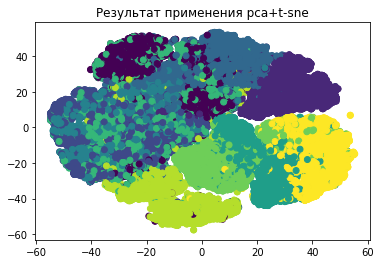

In [31]:
plt.scatter(X_pca_embedded[:60000,0], X_pca_embedded[:60000,1], c=y)
plt.title('Результат применения pca+t-sne')

#### PCA

Text(0.5, 1.0, 'Результат применения pca')

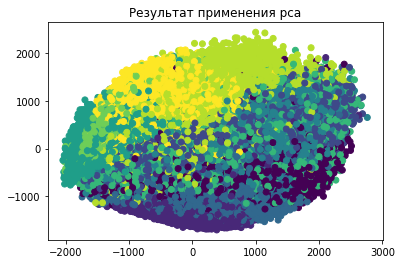

In [35]:
plt.scatter(X_pca[:60000,0], X_pca[:60000,1], c=y)
plt.title('Результат применения pca')

In [6]:
# Стратегия кросс-валидации
# 3 разбиения для такого большого датасета хватит, иначе комп не тянет
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
# Метрики качеств
scorer = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
# Далее поиск по сетке будет осуществляться рандомным выбором точек в сетке, 
# или, если алгоритм не долго обучается, полным перебором по сетке

# если использовать кросс-валидацию, то данные следует разбить на 2 части. Первая из
# них будет использоваться для обучения алгоритмов и оценки качества с помощью кросс-валидации, после
# чего лучший алгоритм будет проверен на адекватность на контрольной выборке. Но тут я этого делать не стану,
# так как контрольная выборка на Каггле

# Logistic Regression
###### После того как прогнал этот алогритм по сетке, выяснилось, что лучший солвер - 'newton-cg', лучшая константа C: 20

###### 1. Логистическая регрессия с понижением размерности PCA до 30 компонент.

In [36]:
LogReg = LogisticRegression(n_jobs=-1)
model_log_reg = Pipeline(steps = [('scaling', MinMaxScaler()),('dim_red', PCA(n_components=30)), ('classifier', LogReg)])
model_log_reg.get_params().keys() # Глянем какие параметры доступны для Тюнинга

dict_keys(['memory', 'steps', 'scaling', 'dim_red', 'classifier', 'scaling__copy', 'scaling__feature_range', 'dim_red__copy', 'dim_red__iterated_power', 'dim_red__n_components', 'dim_red__random_state', 'dim_red__svd_solver', 'dim_red__tol', 'dim_red__whiten', 'classifier__C', 'classifier__class_weight', 'classifier__dual', 'classifier__fit_intercept', 'classifier__intercept_scaling', 'classifier__max_iter', 'classifier__multi_class', 'classifier__n_jobs', 'classifier__penalty', 'classifier__random_state', 'classifier__solver', 'classifier__tol', 'classifier__verbose', 'classifier__warm_start'])

In [37]:
parameters = {
    'classifier__C': [20],
    'classifier__solver': ['newton-cg']
}
grid_cv_lr = GridSearchCV(model_log_reg, parameters, scoring=scorer, cv=cv, n_jobs=-1, refit='accuracy', return_train_score=False)
# random_cv_lr = RandomizedSearchCV(model_log_reg, parameters, scoring=scorer, cv=cv, n_jobs=-1, refit='accuracy', random_state=42, n_iter=20)

In [38]:
%%time
grid_cv_lr.fit(X, y)
result_lr_cv_search = grid_cv_lr.cv_results_

Wall time: 2min 6s


In [39]:
get_result_from_grid_cv(result_lr_cv_search, grid_cv_lr)

{'classifier__C': 20, 'classifier__solver': 'newton-cg'} 
 best_accuracy:  0.8111833333333334
f1_macro_best: 0.8074799748939907 
 precision_macro_best: 0.8069711390107758 
 recall_macro_best: 0.8111833333333334


###### 2. Логистическая регрессия с понижением размерности t-SNE.

In [41]:
LogReg = LogisticRegression(n_jobs=-1)
model_log_reg = Pipeline(steps = [('scaling', StandardScaler()), ('classifier', LogReg)])
model_log_reg.get_params().keys() # Глянем какие параметры доступны для Тюнинга

dict_keys(['memory', 'steps', 'scaling', 'classifier', 'scaling__copy', 'scaling__with_mean', 'scaling__with_std', 'classifier__C', 'classifier__class_weight', 'classifier__dual', 'classifier__fit_intercept', 'classifier__intercept_scaling', 'classifier__max_iter', 'classifier__multi_class', 'classifier__n_jobs', 'classifier__penalty', 'classifier__random_state', 'classifier__solver', 'classifier__tol', 'classifier__verbose', 'classifier__warm_start'])

In [43]:
parameters = {
    'classifier__C': [20],
    'classifier__solver': ['newton-cg']
}
grid_cv_lr = GridSearchCV(model_log_reg, parameters, scoring=scorer, cv=cv, n_jobs=-1, refit='accuracy', return_train_score=False)
# random_cv_lr = RandomizedSearchCV(model_log_reg, parameters, scoring=scorer, cv=cv, n_jobs=-1, refit='accuracy', random_state=42, n_iter=20)

In [44]:
%%time
grid_cv_lr.fit(X_embedded[:60000], y)
result_lr_cv_search = grid_cv_lr.cv_results_

Wall time: 6.11 s


In [45]:
get_result_from_grid_cv(result_lr_cv_search, grid_cv_lr)

{'classifier__C': 20, 'classifier__solver': 'newton-cg'} 
 best_accuracy:  0.6595333333333333
f1_macro_best: 0.6486377366230079 
 precision_macro_best: 0.6479445497002364 
 recall_macro_best: 0.6595333333333333


# KNN

In [7]:
knn = KNN(n_jobs=-1)
model_knn = Pipeline(steps = [('scaling', MinMaxScaler()), ('classifier', knn)])
model_knn.get_params().keys() # Глянем какие параметры доступны для Тюнинга

dict_keys(['memory', 'steps', 'scaling', 'classifier', 'scaling__copy', 'scaling__feature_range', 'classifier__algorithm', 'classifier__leaf_size', 'classifier__metric', 'classifier__metric_params', 'classifier__n_jobs', 'classifier__n_neighbors', 'classifier__p', 'classifier__weights'])

In [8]:
parameters = {
    'classifier__n_neighbors': [1, 3, 5, 7, 9, 12, 15, 35],
    'classifier__p': [1, 2],
    'classifier__algorithm' : ['ball_tree', 'kd_tree', 'brute']
}
# grid_cv_knn = GridSearchCV(model_knn, parameters, scoring=scorer, cv=cv, n_jobs=-1, refit='accuracy', return_train_score=False)
random_cv_knn = RandomizedSearchCV(model_knn, parameters, scoring=scorer, cv=cv, n_jobs=-1, refit='accuracy', random_state=42, n_iter=10)

In [9]:
%%time
random_cv_knn.fit(X[:1000], y[:1000])
result_knn_cv_search = random_cv_knn.cv_results_

Wall time: 34.9 s


In [10]:
get_result_from_grid_cv(result_knn_cv_search, random_cv_knn)

{'classifier__p': 1, 'classifier__n_neighbors': 5, 'classifier__algorithm': 'ball_tree'} 
 best_accuracy:  0.734
f1_macro_best: 0.7350737583484885 
 precision_macro_best: 0.7522628952329535 
 recall_macro_best: 0.7394603548976624


# GaussNB

In [11]:
GausNB = GaussianNB()
model_GausNB = Pipeline(steps = [('scaling', MinMaxScaler()), ('classifier', GausNB)])
model_GausNB.get_params().keys() # Глянем какие параметры доступны для Тюнинга

dict_keys(['memory', 'steps', 'scaling', 'classifier', 'scaling__copy', 'scaling__feature_range', 'classifier__priors', 'classifier__var_smoothing'])

In [12]:
parameters = {
    'classifier__var_smoothing': [0.1, 0.2, 0.5, 1]
}
grid_cv_GB = GridSearchCV(model_GausNB, parameters, scoring=scorer, cv=cv, n_jobs=-1, refit='accuracy', return_train_score=False)
# random_cv_GB = RandomizedSearchCV(model_GausNB, parameters, scoring=scorer, cv=cv, n_jobs=-1, refit='accuracy', random_state=42, n_iter=10)

In [13]:
%%time
grid_cv_GB.fit(X[:10000], y[:10000])
result_GB_cv_search = grid_cv_GB.cv_results_

Wall time: 12.8 s


In [14]:
get_result_from_grid_cv(result_GB_cv_search, grid_cv_GB)

{'classifier__var_smoothing': 0.1} 
 best_accuracy:  0.6778
f1_macro_best: 0.6649761636489562 
 precision_macro_best: 0.6839084679309568 
 recall_macro_best: 0.6769306362850727


# LinearSVC
$\langle x, x'\rangle$

In [ ]:
# 1. Without PCA
# {'classifier__C': 0.1, 'classifier__loss': 'hinge'} 
# best_accuracy:  0.85145

# 2. With PCA (n_comp=30)
# {'classifier__C': 0.1, 'classifier__loss': 'squared_hinge'} 
#  best_accuracy:  0.8064333333333333

# 3. With t-sne 
# {'classifier__C': 0.1, 'classifier__loss': 'squared_hinge'} 
#  best_accuracy:  0.6463

In [57]:
linear_SVC = LinearSVC(dual=True, penalty='l2')
model_linear_SVC = Pipeline(steps = [('scaling', MinMaxScaler()), ('classifier', linear_SVC)])
model_linear_SVC.get_params().keys() # Глянем какие параметры доступны для Тюнинга

dict_keys(['memory', 'steps', 'scaling', 'classifier', 'scaling__copy', 'scaling__feature_range', 'classifier__C', 'classifier__class_weight', 'classifier__dual', 'classifier__fit_intercept', 'classifier__intercept_scaling', 'classifier__loss', 'classifier__max_iter', 'classifier__multi_class', 'classifier__penalty', 'classifier__random_state', 'classifier__tol', 'classifier__verbose'])

In [58]:
# когда C большой, он будет корректно классифицировать все точки данных, то есть оверфитить модель
# при C->inf будет соответствовать hard-margin svm
parameters = {
    'classifier__loss':['hinge', 'squared_hinge'],
    'classifier__C':[0.1, 0.001, 0.01, 0.0009, 0.0005]
}
grid_cv_LSVC = GridSearchCV(model_linear_SVC, parameters, scoring=scorer, cv=cv, n_jobs=-1, refit='accuracy', return_train_score=False)
# random_cv_LSVC = RandomizedSearchCV(model_linear_SVC, parameters, scoring=scorer, cv=cv, n_jobs=-1, refit='accuracy', random_state=42, n_iter=10)

In [59]:
%%time
grid_cv_LSVC.fit(X_embedded[:60000], y)
result_LSVC_cv_search = grid_cv_LSVC.cv_results_

Wall time: 7.55 s


In [60]:
get_result_from_grid_cv(result_LSVC_cv_search, grid_cv_LSVC)

{'classifier__C': 0.1, 'classifier__loss': 'squared_hinge'} 
 best_accuracy:  0.6463
f1_macro_best: 0.6206338905242 
 precision_macro_best: 0.6433306326566691 
 recall_macro_best: 0.6463


# PolySVC 
$(\gamma \langle x, x'\rangle + r)^d$

In [64]:
poly_SVC = SVC(random_state=42, kernel='poly', cache_size=500)
model_poly_SVC = Pipeline(steps = [('scaling', MinMaxScaler()), ('classifier', poly_SVC)])
model_poly_SVC.get_params().keys() # Глянем какие параметры доступны для Тюнинга

dict_keys(['memory', 'steps', 'scaling', 'classifier', 'scaling__copy', 'scaling__feature_range', 'classifier__C', 'classifier__cache_size', 'classifier__class_weight', 'classifier__coef0', 'classifier__decision_function_shape', 'classifier__degree', 'classifier__gamma', 'classifier__kernel', 'classifier__max_iter', 'classifier__probability', 'classifier__random_state', 'classifier__shrinking', 'classifier__tol', 'classifier__verbose'])

In [65]:
# когда C большой, он будет корректно классифицировать все точки данных, то есть оверфитить модель
# при C->inf будет соответствовать hard-margin svm
# coef0 контролирует, насколько на модель влияют полиномы высокой степени.
# gammaо пределяет, какое влияние оказывает отдельный учебный пример. 
#                  Чем больше gamma, тем ближе другие примеры должны быть затронуты.

parameters = {
    'classifier__degree':[2,3],
    'classifier__C':[0.0005, 0.005, 0.001, 0.01],
    'classifier__gamma':[1000, 300, 100, 10],
    'classifier__coef0': [0,1,10]
}
# grid_cv_PSVC = GridSearchCV(model_poly_SVC, parameters, scoring=scorer, cv=cv, n_jobs=-1, refit='accuracy', return_train_score=False)
random_cv_PSVC = RandomizedSearchCV(model_poly_SVC, parameters, scoring=scorer, cv=cv, n_jobs=-1, refit='accuracy', random_state=42, n_iter=10)

In [ ]:
%%time
random_cv_PSVC.fit(X, y)
result_PSVC_cv_search = random_cv_PSVC.cv_results_

In [ ]:
get_result_from_grid_cv(result_PSVC_cv_search, random_cv_PSVC)

# LDA

In [1]:
# SPCA, t-sne
# спецкурс по обработке изображений ВМК МГУ Конушин

In [61]:
lda = LDA()
model_LDA = Pipeline(steps = [('scaling', MinMaxScaler()), ('classifier', lda)])
model_LDA.get_params().keys() # Глянем какие параметры доступны для Тюнинга

dict_keys(['memory', 'steps', 'scaling', 'classifier', 'scaling__copy', 'scaling__feature_range', 'classifier__n_components', 'classifier__priors', 'classifier__shrinkage', 'classifier__solver', 'classifier__store_covariance', 'classifier__tol'])

In [62]:
%%time
lda_scoring = cross_val_score(model_LDA, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy mean: {}, std: {}'.format(lda_scoring.mean(), lda_scoring.std()))

Accuracy mean: 0.8225333333333333, std: 0.004087854639729216
Wall time: 24.6 s


# Decision Tree

In [17]:
dec_tree = DecisionTreeClassifier()

In [18]:
%%time
dec_tree_scoring = cross_val_score(dec_tree, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy mean: {}, std: {}'.format(dec_tree_scoring.mean(), dec_tree_scoring.std()))

Accuracy mean: 0.7882666666666668, std: 0.002896070134202932
Wall time: 58.9 s


In [19]:
dec_tree = DecisionTreeClassifier(min_samples_split=10, max_depth=10)
dec_tree.fit(X,y)
accuracy_score(y, dec_tree.predict(X))

0.8459

In [29]:
dec_tree = DecisionTreeClassifier(min_samples_split=10, max_depth=10)
pipeline_tree = Pipeline(steps=[('scaler', StandardScaler()), ('dim_red',PCA(n_components=30)), ('model', dec_tree)])
pipeline_tree.fit(X,y)
accuracy_score(y, pipeline_tree.predict(X))

0.8059166666666666

# PCA

In [30]:
dim_red_pca = PCA(n_components=50)
X_transform = dim_red_pca.fit_transform(X)

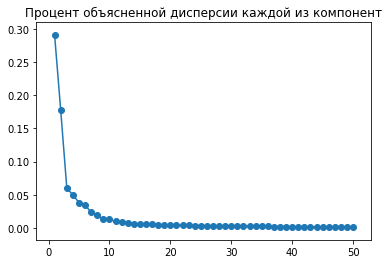

In [46]:
explain_vars = dim_red_pca.explained_variance_ratio_
plt.plot(np.arange(1, len(explain_vars)+1, 1), explain_vars)
plt.scatter(np.arange(1, len(explain_vars)+1, 1), explain_vars)
plt.title('Процент объясненной дисперсии каждой из компонент')
plt.show()

# RandomForest

In [ ]:
# -